## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Functions:

In [2]:
#from s-vector to s-matrix
def Vec_Mat(S):
    
    S_mat = np.zeros((11,13))
    for i in range(11):
        S_mat[i,:] = S[i*13:(i+1)*13]
        
    return S_mat

#Euclidean norm
def norm_2(v):
    return np.sqrt(np.dot(v,v))

#Noise function
def noise_func(mini, maxi, x):
    
    noise = np.random.normal(mini, maxi, len(x))
    noise = noise / norm_2(noise)
    noise = 1 / 18 * noise * norm_2(x)
    
    return noise

#G-matrix
def G_matrix(first, last, split):
    
    G = np.zeros((first,last))
    for i in range(first):
        if i < split:
            for j in range(i+2):
                G[i, j * 13 + i + 1 - j] = np.sqrt(2)*1000
                
        else:
            for j in range(20-i+1):
                G[i, j * 13 - 8 + i + j] = np.sqrt(2)*1000
    
    return G

#s-matrix
def s_matrix(len_x, len_y, diff_vel, array_grey, top, bot):
    
    zero      = np.zeros(len_x)
    grey_area = array_grey / diff_vel
    
    empty = []
    for i in range(len_y):
        if i < top:
            empty.append(zero)
        elif i > bot:
            empty.append(zero)
        else:
            empty.append(grey_area)
    
    empty = np.array(empty)
    s     = np.hstack(empty)
    
    return s

## Questions:

Expected (t_ano):
[ 0.          0.          0.          0.         -0.01087857 -0.02175713
 -0.0326357  -0.0326357  -0.0326357  -0.0326357  -0.0326357  -0.0326357
 -0.02175713 -0.01087857  0.          0.          0.          0.
  0.          0.        ]
------------------------------------------------------------------
Observed (t_obs):
[ 1.06038230e-03 -7.52583304e-04  8.73716767e-04  6.04581992e-05
 -9.13275680e-03 -2.06808382e-02 -3.18034528e-02 -3.17501834e-02
 -3.40480430e-02 -3.28571243e-02 -3.27031685e-02 -3.11900849e-02
 -2.15842189e-02 -1.27855654e-02 -5.25753776e-04 -8.25942867e-04
 -1.99173363e-03 -3.37319043e-04  1.54099106e-03 -1.29992798e-04]
------------------------------------------------------------------
Our results:
[ 0.          0.          0.          0.         -0.01087857 -0.02175713
 -0.0326357  -0.0326357  -0.0326357  -0.0326357  -0.0326357  -0.0326357
 -0.02175713 -0.01087857  0.          0.          0.          0.
  0.          0.        ]
-------------------

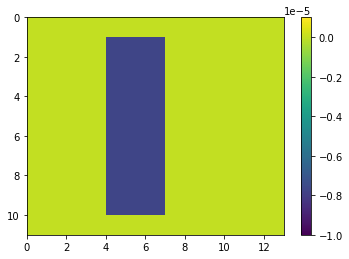

In [3]:
grey     = np.array([0,0,0,0,-1,-1,-1,0,0,0,0,0,0])
dv       = 130000
N_fields = np.array([0,0,0,0,1,2,3,3,3,3,3,3,2,1,0,0,0,0,0,0])
t_ano    = -N_fields * np.sqrt(2)*1000/ dv #Correct values for t.
noise = noise_func(0, 1, t_ano)

t_obs    = t_ano + noise

G  = G_matrix(20, 143, 10)
S  = s_matrix(13, 11, dv, grey, 1, 9)

print('Expected (t_ano):')
print(t_ano)
print('------------------------------------------------------------------')
print('Observed (t_obs):')
print(t_obs)
print('------------------------------------------------------------------')
print('Our results:')
print(np.matmul(G,S))
print('------------------------------------------------------------------')

print('Plot of s-matrix')
plt.imshow(Vec_Mat(S),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()

## Now adding Tikhonov regularization

In [4]:
def tikhonov(first, last, length, g, d, obs):
    
    epsilons = np.logspace(first, last, length)
    values   = np.zeros_like(epsilons)
    
    for i in range(len(epsilons)):
        eps        = epsilons[i]
        s_estimate = np.matmul(np.matmul(np.linalg.inv(np.matmul(g.T, g) + eps**2 * np.eye(d)), g.T), obs)
        value      = abs(np.dot(obs - np.matmul(g, s_estimate), obs - np.matmul(g, s_estimate)) - np.dot(noise, noise))
        values[i]  = value
    
    return epsilons, values


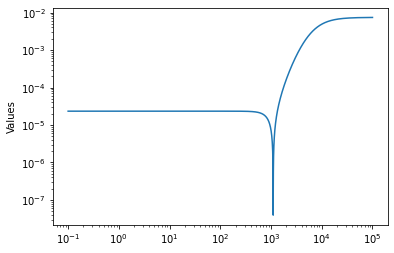

eps is: 1103.0730151526752


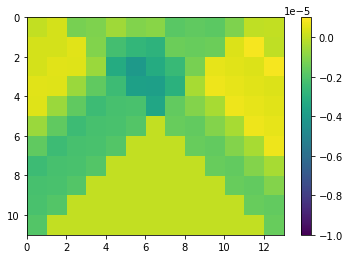

this is the "error": 3.947303857343456e-08


In [5]:
epsi0, val0 = tikhonov(5, -1, 10000, G, 143, t_obs)

plt.plot(epsi0,val0[:])
plt.ylabel('Values')
plt.yscale('log')
plt.xscale('log')
plt.show()

eps = epsi0[np.argmin(val0)]
print('eps is:',eps)
s_estimate = np.matmul(np.matmul(np.linalg.inv(np.matmul(G.T, G) + eps**2 * np.eye(143)), G.T), t_obs)

plt.imshow(Vec_Mat(s_estimate),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()
print('this is the "error":',abs(np.dot(t_obs - np.matmul(G, s_estimate), t_obs - np.matmul(G, s_estimate)) - np.dot(noise, noise)))

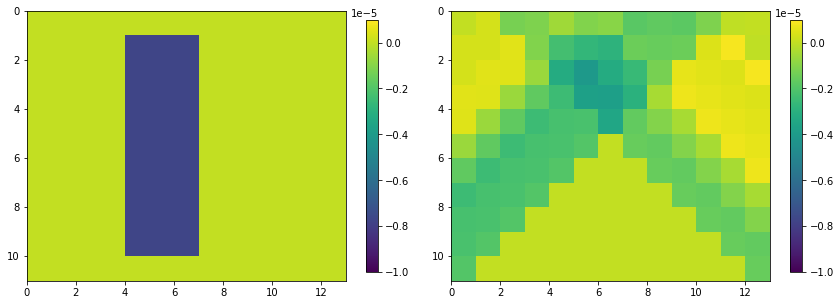

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,12))
ax1.imshow(Vec_Mat(S),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plot2 = ax2.imshow(Vec_Mat(s_estimate),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
fig.colorbar(plot2, ax=ax2,shrink=0.3)
fig.colorbar(plot2, ax=ax1,shrink=0.3)
plt.tight_layout()

(<matplotlib.contour.QuadContourSet at 0x7f20ad1ff700>,
 (0.0, 142.0, 142.0, 0.0),
 Text(0.5, 1.0, 'Resolution matrix'),
 Text(0.5, 0, 'columns'),
 Text(0, 0.5, 'rows'))

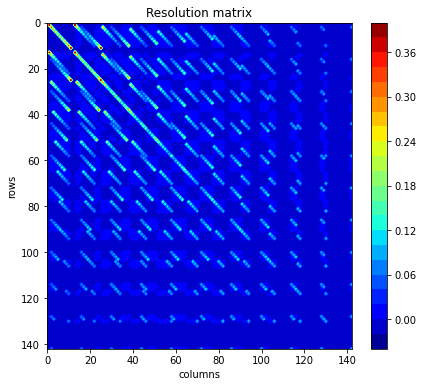

In [6]:
A = np.dot(G.T,G) + eps**2 * np.diag(np.ones(143))
Ginv = np.dot(np.linalg.inv(A),G.T)

R  = np.dot(Ginv,G)


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.contourf(R,levels=20,cmap='jet'),plt.colorbar(),plt.axis([0,143-1,143-1,0]),plt.title('Resolution matrix'),plt.xlabel('columns'),plt.ylabel('rows')


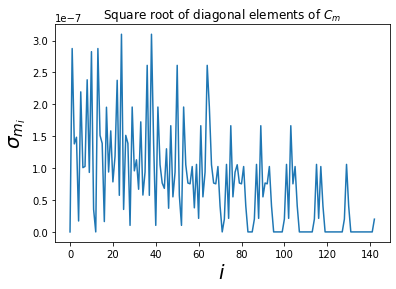

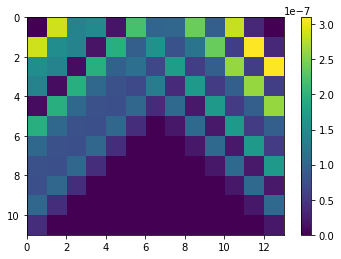

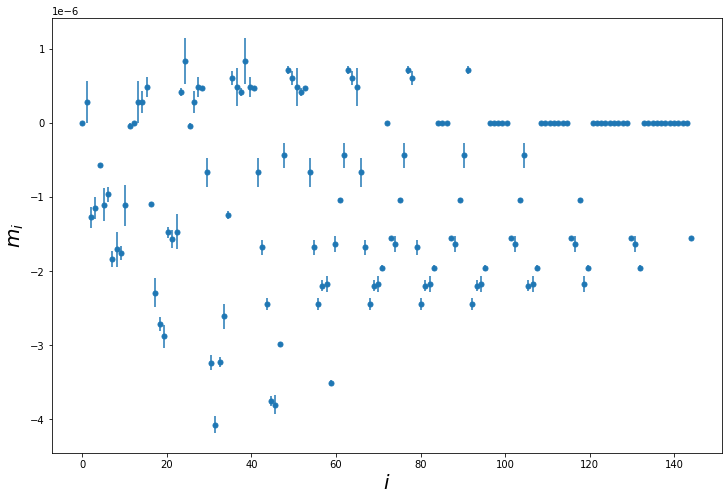

In [16]:
C_d = np.diag(noise*noise)
C_m = np.dot(Ginv,np.dot(C_d,Ginv.T))

#C_m = sigma**2*Ginv

sigma_m = np.sqrt(np.diag(C_m) )

plt.plot(sigma_m   ),plt.title(r'Square root of diagonal elements of $C_m$')#,plt.axis([None,None,0,40])
plt.xlabel(r'$i$',fontsize=20),plt.ylabel(r'$\sigma_{m_i}$',fontsize=20)
plt.figure()
plt.imshow(Vec_Mat(sigma_m),extent=[0,13,11,0])
plt.colorbar()
plt.show()

plt.figure(figsize=(12,8))
plt.errorbar(np.linspace(0,144,143),s_estimate,yerr=sigma_m,fmt='.',markersize=10,label='estimated' )
plt.xlabel(r'$i$',fontsize=20),plt.ylabel(r'${m_i}$',fontsize=20)
plt.show()

## Test2 (har navnet 2 pga. variabel navngaivning)

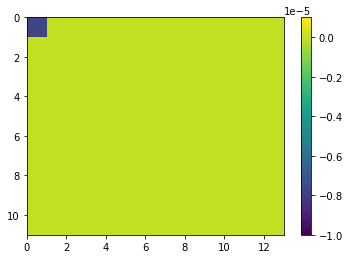

In [8]:
#Creating s
grey2 = np.array([-1,0,0,0,0,0,0,0,0,0,0,0,0])
S2    = s_matrix(13, 11, dv, grey2, 0, 0)

#Plotting s
plt.imshow(Vec_Mat(S2),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()

t_obs2 =np.matmul(G, S2) + noise

epsi2, val2 = tikhonov(8, -1, 10000, G, 143, t_obs2)

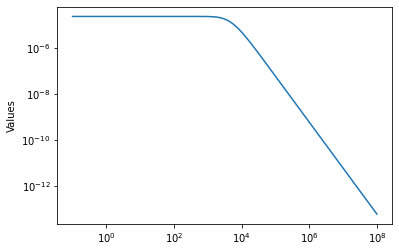

eps is: 100000000.0


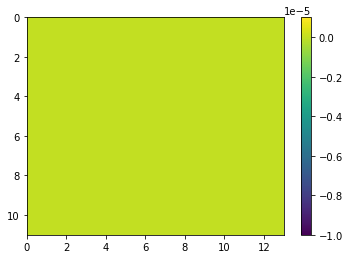

this is the "error": 5.958868991230888e-14


In [9]:
plt.plot(epsi2,val2[:])
plt.ylabel('Values')
plt.yscale('log')
plt.xscale('log')
plt.show()

eps2 = epsi2[np.argmin(val2)]
print('eps is:',eps2)
s_estimate2 = np.matmul(np.matmul(np.linalg.inv(np.matmul(G.T, G) + eps2**2 * np.eye(143)), G.T), t_obs2)

plt.imshow(Vec_Mat(s_estimate2),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()
print('this is the "error":',abs(np.dot(t_obs2 - np.matmul(G, s_estimate2), t_obs2 - np.matmul(G, s_estimate2)) - np.dot(noise, noise)))

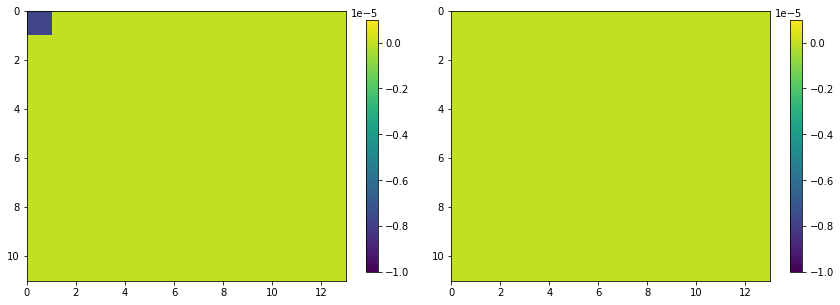

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,12))
ax1.imshow(Vec_Mat(S2),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plot2 = ax2.imshow(Vec_Mat(s_estimate2),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
fig.colorbar(plot2, ax=ax2,shrink=0.3)
fig.colorbar(plot2, ax=ax1,shrink=0.3)
plt.tight_layout()

## Test3

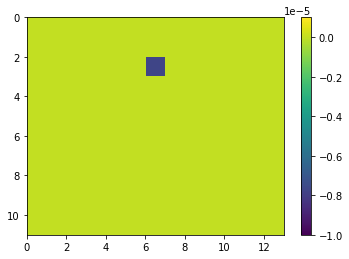

In [10]:
#Creating s
grey3 = np.array([0,0,0,0,0,0,-1,0,0,0,0,0,0])
S3    = s_matrix(13, 11, dv, grey3, 2, 2)

#Plotting s
plt.imshow(Vec_Mat(S3),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()

t_obs3 =np.matmul(G, S3) + noise

epsi3, val3 = tikhonov(8, -1, 10000, G, 143, t_obs3)

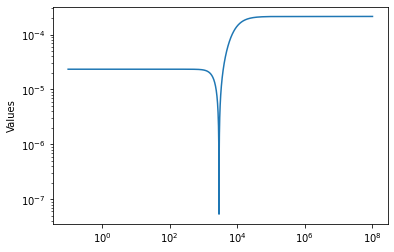

eps is: 2895.6507168328158


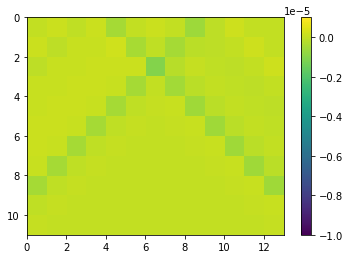

this is the "error": 5.3737568420372204e-08


In [11]:
plt.plot(epsi3,val3[:])
plt.ylabel('Values')
plt.yscale('log')
plt.xscale('log')
plt.show()

eps3 = epsi3[np.argmin(val3)]
print('eps is:',eps3)
s_estimate3 = np.matmul(np.matmul(np.linalg.inv(np.matmul(G.T, G) + eps3**2 * np.eye(143)), G.T), t_obs3)

plt.imshow(Vec_Mat(s_estimate3),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()
print('this is the "error":',abs(np.dot(t_obs3 - np.matmul(G, s_estimate3), t_obs3 - np.matmul(G, s_estimate3)) - np.dot(noise, noise)))


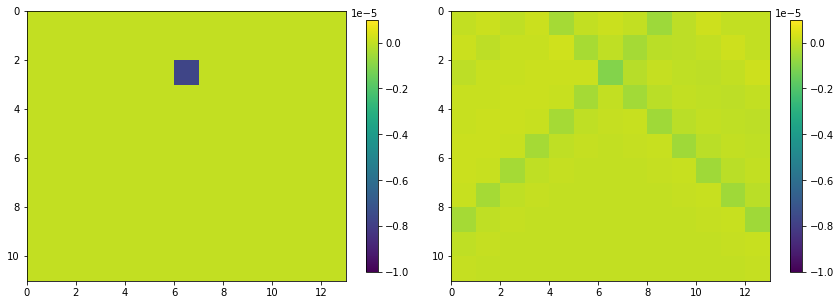

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,12))
ax1.imshow(Vec_Mat(S3),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plot2 = ax2.imshow(Vec_Mat(s_estimate3),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
fig.colorbar(plot2, ax=ax2,shrink=0.3)
fig.colorbar(plot2, ax=ax1,shrink=0.3)
plt.tight_layout()

## Test 4

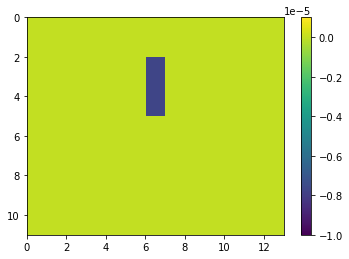

In [12]:
#Creating s
grey4 = np.array([0,0,0,0,0,0,-1,0,0,0,0,0,0])
S4    = s_matrix(13, 11, dv, grey4, 2, 4)

#Plotting s
plt.imshow(Vec_Mat(S4),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()

t_obs4 =np.matmul(G, S4) + noise

epsi4, val4 = tikhonov(5, -1, 10000, G, 143, t_obs4)

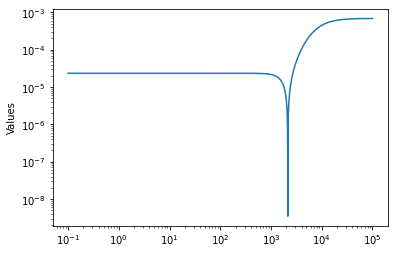

eps is: 2138.1245656306764


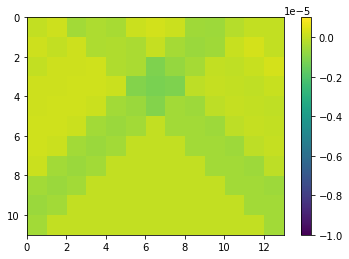

this is the "error": 3.4789828791467606e-09


In [13]:
plt.plot(epsi4,val4[:])
plt.ylabel('Values')
plt.yscale('log')
plt.xscale('log')
plt.show()

eps4 = epsi4[np.argmin(val4)]
print('eps is:',eps4)
s_estimate4 = np.matmul(np.matmul(np.linalg.inv(np.matmul(G.T, G) + eps4**2 * np.eye(143)), G.T), t_obs4)

plt.imshow(Vec_Mat(s_estimate4),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()
print('this is the "error":',abs(np.dot(t_obs4 - np.matmul(G, s_estimate4), t_obs4 - np.matmul(G, s_estimate4)) - np.dot(noise, noise)))


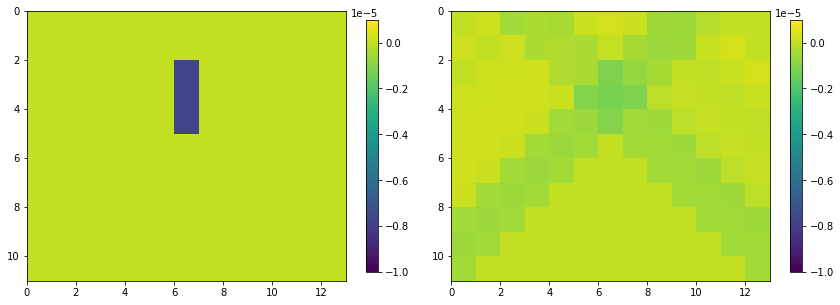

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,12))
ax1.imshow(Vec_Mat(S4),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plot2 = ax2.imshow(Vec_Mat(s_estimate4),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
fig.colorbar(plot2, ax=ax2,shrink=0.3)
fig.colorbar(plot2, ax=ax1,shrink=0.3)
plt.tight_layout()

## Test 5

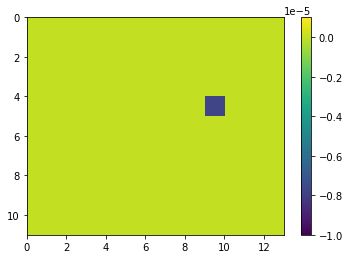

In [14]:
#Creating s
grey5 = np.array([0,0,0,0,0,0,0,0,0,-1,0,0,0])
S5    = s_matrix(13, 11, dv, grey5, 4, 4)

#Plotting s
plt.imshow(Vec_Mat(S5),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()

t_obs5 =np.matmul(G, S5) + noise

epsi5, val5 = tikhonov(8, -1, 10000, G, 143, t_obs5)

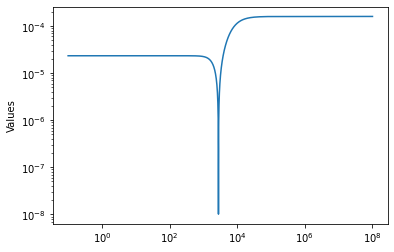

eps is: 2789.616829636374


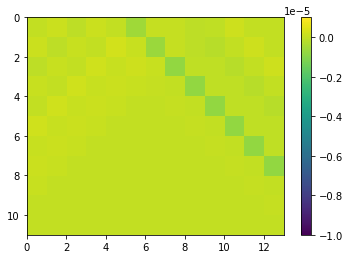

this is the "error": 1.0131657709926345e-08


In [15]:
plt.plot(epsi5,val5[:])
plt.ylabel('Values')
plt.yscale('log')
plt.xscale('log')
plt.show()

eps5 = epsi5[np.argmin(val5)]
print('eps is:',eps5)
s_estimate5 = np.matmul(np.matmul(np.linalg.inv(np.matmul(G.T, G) + eps5**2 * np.eye(143)), G.T), t_obs5)

plt.imshow(Vec_Mat(s_estimate5),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()
print('this is the "error":',abs(np.dot(t_obs5 - np.matmul(G, s_estimate5), t_obs5 - np.matmul(G, s_estimate5)) - np.dot(noise, noise)))


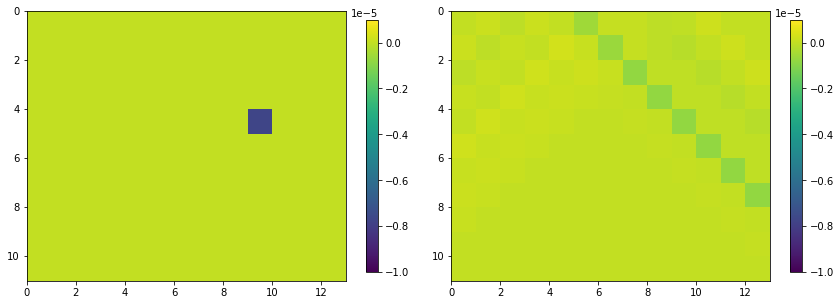

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,12))
ax1.imshow(Vec_Mat(S5),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plot2 = ax2.imshow(Vec_Mat(s_estimate5),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
fig.colorbar(plot2, ax=ax2,shrink=0.3)
fig.colorbar(plot2, ax=ax1,shrink=0.3)
plt.tight_layout()

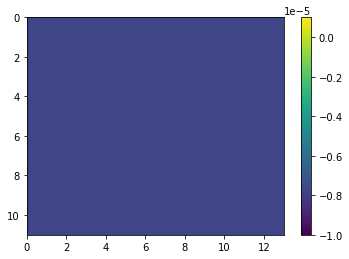

In [60]:
#Creating s
grey5 = np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
S5    = s_matrix(13, 11, dv, grey5, 0, 10)

#Plotting s
plt.imshow(Vec_Mat(S5),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()

t_obs5 =np.matmul(G, S5) + noise

epsi5, val5 = tikhonov(8, -1, 10000, G, 143, t_obs5)

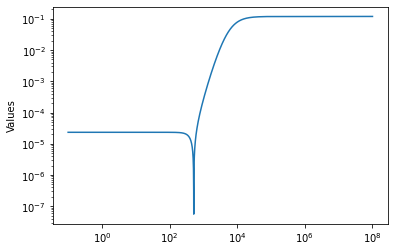

eps is: 518.4077281523826


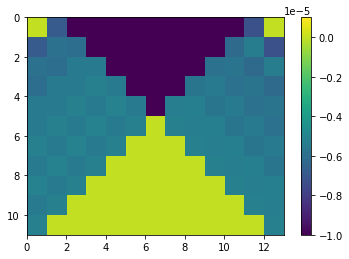

this is the "error": 5.620399961345026e-08


In [61]:
plt.plot(epsi5,val5[:])
plt.ylabel('Values')
plt.yscale('log')
plt.xscale('log')
plt.show()

eps5 = epsi5[np.argmin(val5)]
print('eps is:',eps5)
s_estimate5 = np.matmul(np.matmul(np.linalg.inv(np.matmul(G.T, G) + eps5**2 * np.eye(143)), G.T), t_obs5)

plt.imshow(Vec_Mat(s_estimate5),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plt.colorbar()
plt.show()
print('this is the "error":',abs(np.dot(t_obs5 - np.matmul(G, s_estimate5), t_obs5 - np.matmul(G, s_estimate5)) - np.dot(noise, noise)))


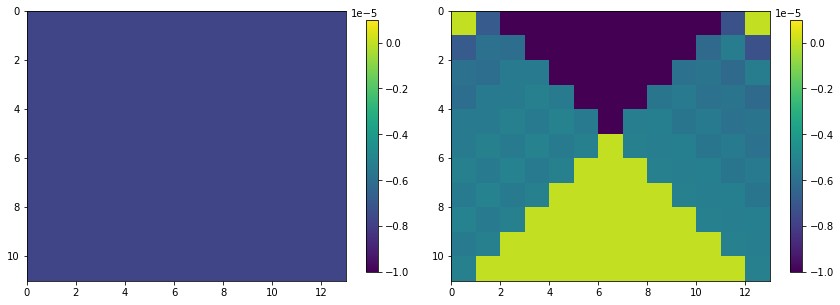

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,12))
ax1.imshow(Vec_Mat(S5),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
plot2 = ax2.imshow(Vec_Mat(s_estimate5),extent=[0,13,11,0],vmin=-1*10**(-5), vmax=10**(-6))
fig.colorbar(plot2, ax=ax2,shrink=0.3)
fig.colorbar(plot2, ax=ax1,shrink=0.3)
plt.tight_layout()